# Marvik Challenge

In [148]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Links:


*   https://www.sciencedirect.com/science/article/pii/S2666827022000378 (Potential features, good information about why LSTM can predict stock price, hyperparameter tuning, more theorical and detailed approach)
*   https://fred.stlouisfed.org (Historical data about UNRATE and UMCSENT)
*   https://finance.yahoo.com/ (Historical data about VIX, USDX and MSFT)
*   https://medium.com/the-handbook-of-coding-in-finance/stock-prices-prediction-using-long-short-term-memory-lstm-model-in-python-734dd1ed6827 (Code template to organize the data and run the model, practical)
*   https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/ (Additional information about hyperparameters)



Important quotes:


*    LSTM, a typical recurrent neural network architecture, is designed to overcome the vanishing gradient problem (Hochreiter, 1998). Memorizing information for a longer period of time is the default behavior of the LSTM model
*    Long Short-Term Memory models are extremely powerful time-series models. They can predict an arbitrary number of steps into the future.

Potential features
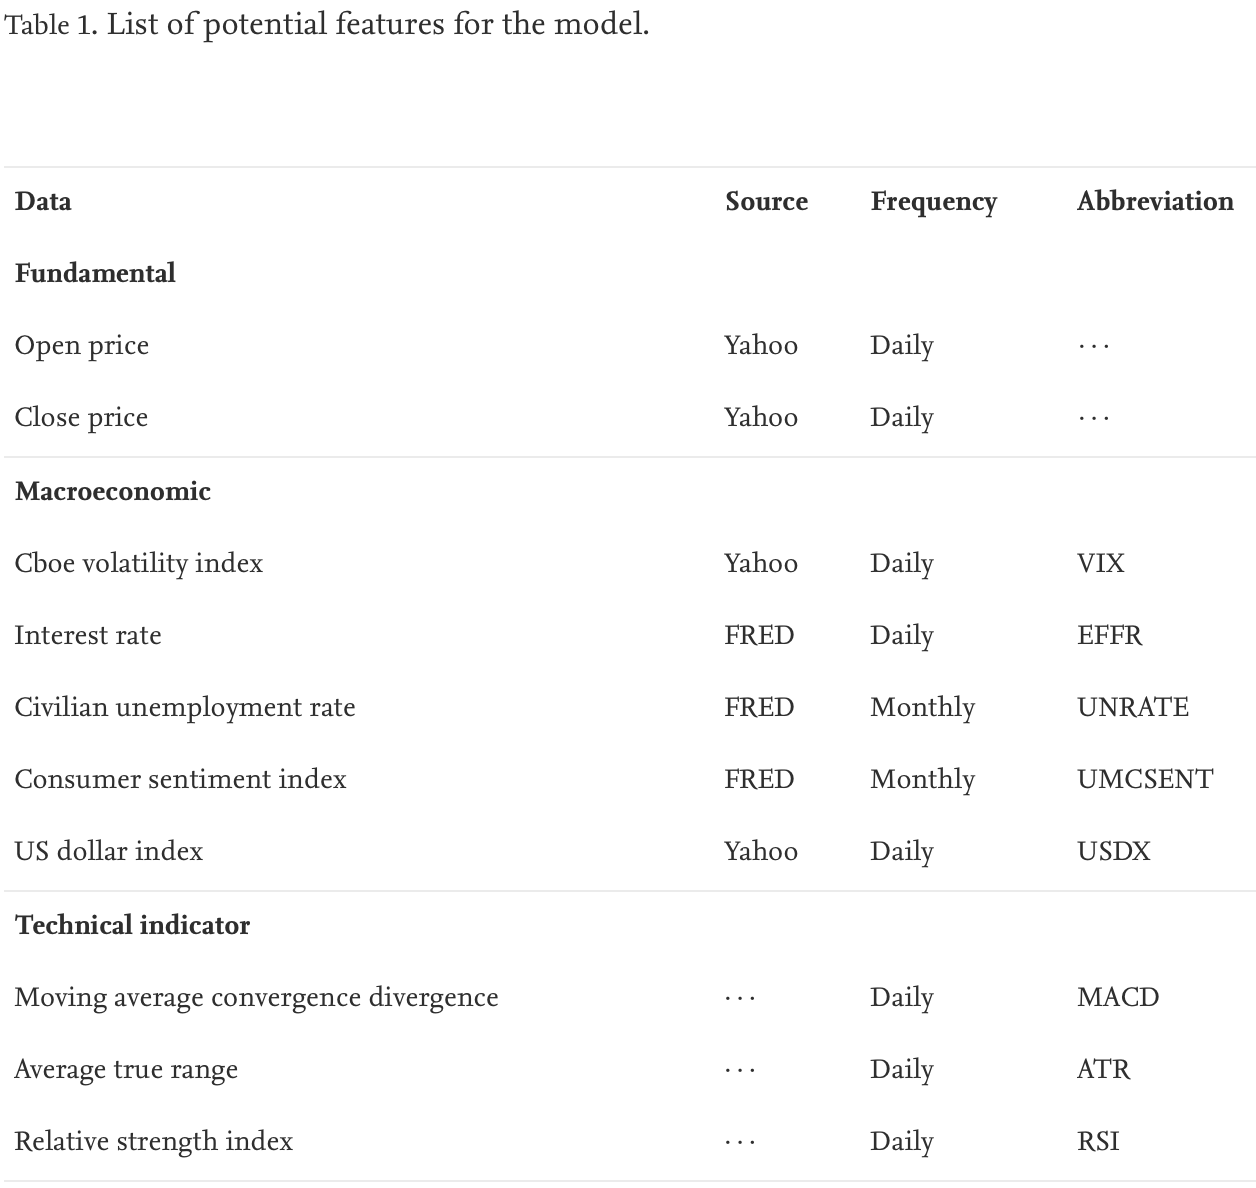




Approach:
I found a link with a strong theoretical approach (Science Direct) to know what I needed to do to solve the problem before actually applying the model with some template. I read it and extracted the main ideas to solve my problem. I looked up the information in other sources (Yahoo Finance, FRED) and mix code of mine with some templates following the guidance of the Science Direct post. This post helped me to understand the basics of what I was doing in the code and why LSTM was a good solution.

## Generate dataset

### Stock data (MSFT)

In [149]:
stock_data = pd.read_csv("MSFT.csv")
stock_data["Date"] = pd.to_datetime(stock_data.Date)
stock_data["period"] = stock_data["Date"].dt.to_period("M")
print(stock_data.info())
print(stock_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9160 entries, 0 to 9159
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9160 non-null   datetime64[ns]
 1   Open       9160 non-null   float64       
 2   High       9160 non-null   float64       
 3   Low        9160 non-null   float64       
 4   Close      9160 non-null   float64       
 5   Adj Close  9160 non-null   float64       
 6   Volume     9160 non-null   int64         
 7   period     9160 non-null   period[M]     
dtypes: datetime64[ns](1), float64(5), int64(1), period[M](1)
memory usage: 572.6 KB
None
        Date      Open      High       Low     Close  Adj Close      Volume  \
0 1986-03-13  0.088542  0.101563  0.088542  0.097222   0.061109  1031788800   
1 1986-03-14  0.097222  0.102431  0.097222  0.100694   0.063292   308160000   
2 1986-03-17  0.100694  0.103299  0.100694  0.102431   0.064384   133171200   
3 1986-03-18  0.10

### US dollar index

In [150]:
us_dolar_index_df = pd.read_csv("USDX.csv")
us_dolar_index_df["Date"] = pd.to_datetime(us_dolar_index_df.Date)
us_dolar_index_df.drop(labels=us_dolar_index_df.columns.difference(["Date","Close"]),axis=1,inplace=True)
us_dolar_index_df.rename(columns={"Close": "USDX"}, inplace=True)
print(us_dolar_index_df.info())
print(us_dolar_index_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15997 entries, 0 to 15996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    15997 non-null  datetime64[ns]
 1   USDX    13099 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 250.1 KB
None
        Date        USDX
0 1971-01-04  120.529999
1 1971-01-05  120.519997
2 1971-01-06  120.489998
3 1971-01-07  120.550003
4 1971-01-08  120.529999


### Cboe volatility index

In [151]:
cboe_volatility_index_df = pd.read_csv("VIX.csv")
cboe_volatility_index_df["Date"] = pd.to_datetime(cboe_volatility_index_df.Date)
cboe_volatility_index_df.drop(labels=cboe_volatility_index_df.columns.difference(["Date","Close"]),axis=1,inplace=True)
cboe_volatility_index_df.rename(columns={"Close": "VIX"}, inplace=True)
print(cboe_volatility_index_df.info())
print(cboe_volatility_index_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8198 entries, 0 to 8197
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8198 non-null   datetime64[ns]
 1   VIX     8198 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.2 KB
None
        Date        VIX
0 1990-01-02  17.240000
1 1990-01-03  18.190001
2 1990-01-04  19.219999
3 1990-01-05  20.110001
4 1990-01-08  20.260000


### Interest rate

In [152]:
interest_rate_df = pd.read_csv("EFFR.csv")
interest_rate_df["DATE"] = pd.to_datetime(interest_rate_df.DATE)
interest_rate_df.drop(labels=interest_rate_df[interest_rate_df.EFFR == "."].index,axis=0,inplace=True)
print(interest_rate_df.info())
print(interest_rate_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5534 entries, 0 to 5748
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    5534 non-null   datetime64[ns]
 1   EFFR    5534 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 129.7+ KB
None
        DATE  EFFR
0 2000-07-03  7.03
2 2000-07-05  6.52
3 2000-07-06  6.51
4 2000-07-07  6.42
5 2000-07-10  6.51


### Unemployment rate

In [153]:
unemployment_rate_df = pd.read_csv("UNRATE.csv")
unemployment_rate_df["DATE"] = pd.to_datetime(unemployment_rate_df.DATE)
unemployment_rate_df.rename(columns={"DATE":"period"},inplace=True)
unemployment_rate_df["period"] = unemployment_rate_df["period"].dt.to_period("M")
print(unemployment_rate_df.info())
print(unemployment_rate_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   period  894 non-null    period[M]
 1   UNRATE  894 non-null    float64  
dtypes: float64(1), period[M](1)
memory usage: 14.1 KB
None
    period  UNRATE
0  1948-01     3.4
1  1948-02     3.8
2  1948-03     4.0
3  1948-04     3.9
4  1948-05     3.5


### Consumer sentiment index

In [154]:
consumer_sentiment_df = pd.read_csv("UMCSENT.csv")
consumer_sentiment_df["DATE"] = pd.to_datetime(consumer_sentiment_df.DATE)
consumer_sentiment_df.rename(columns={"DATE":"period"},inplace=True)
consumer_sentiment_df["period"] = consumer_sentiment_df["period"].dt.to_period("M")
consumer_sentiment_df.drop(labels=consumer_sentiment_df[consumer_sentiment_df.UMCSENT == "."].index,axis=0,inplace=True)
print(consumer_sentiment_df.info())
print(consumer_sentiment_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 625 entries, 0 to 834
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype    
---  ------   --------------  -----    
 0   period   625 non-null    period[M]
 1   UMCSENT  625 non-null    object   
dtypes: object(1), period[M](1)
memory usage: 14.6+ KB
None
     period UMCSENT
0   1952-11    86.2
3   1953-02    90.7
9   1953-08    80.8
12  1953-11    80.7
15  1954-02      82


### Merge datasets

In [155]:
df = stock_data.set_index('Date').join(cboe_volatility_index_df.set_index("Date"),how="inner")


In [156]:
df = df.join(us_dolar_index_df.set_index("Date"),how="inner")

In [157]:
df = df.join(interest_rate_df.set_index("DATE"),how="inner")

In [158]:
df = df.join(unemployment_rate_df.set_index("period"),on="period",how="inner")

In [159]:
df = df.join(consumer_sentiment_df.set_index("period"),on="period",how="inner")

In [160]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5466 entries, 2000-07-03 to 2022-05-31
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype    
---  ------     --------------  -----    
 0   Open       5466 non-null   float64  
 1   High       5466 non-null   float64  
 2   Low        5466 non-null   float64  
 3   Close      5466 non-null   float64  
 4   Adj Close  5466 non-null   float64  
 5   Volume     5466 non-null   int64    
 6   period     5466 non-null   period[M]
 7   VIX        5466 non-null   float64  
 8   USDX       5466 non-null   float64  
 9   EFFR       5466 non-null   object   
 10  UNRATE     5466 non-null   float64  
 11  UMCSENT    5466 non-null   object   
dtypes: float64(8), int64(1), object(2), period[M](1)
memory usage: 555.1+ KB
None
                 Open      High       Low     Close  Adj Close    Volume  \
2000-07-03  39.843750  40.03125  39.68750  40.00000  25.142197  15734800   
2000-07-05  39.937500  39.93750  39.12500  39.25000 

In [161]:
df["EFFR"] = df.EFFR.astype(float)
df["UMCSENT"] = df.UMCSENT.astype(float)

<AxesSubplot:>

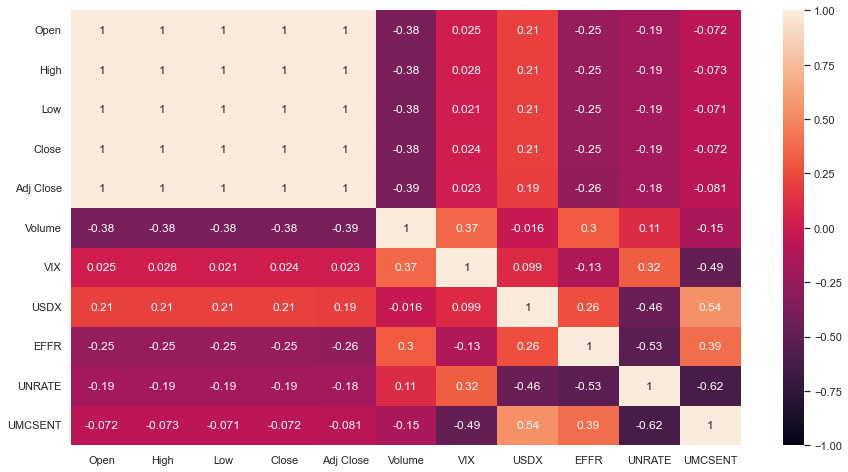

In [162]:
sns.set(rc = {'figure.figsize':(15,8)})
corr_m = df.corr()

sns.heatmap(corr_m, annot=True,vmin=-1,vmax=1)

Open, High, Adj Close and Low are highly correlated

In [163]:
df.drop(labels=["Open", "High", "Low","period","Adj Close"],axis=1,inplace=True)

<AxesSubplot:>

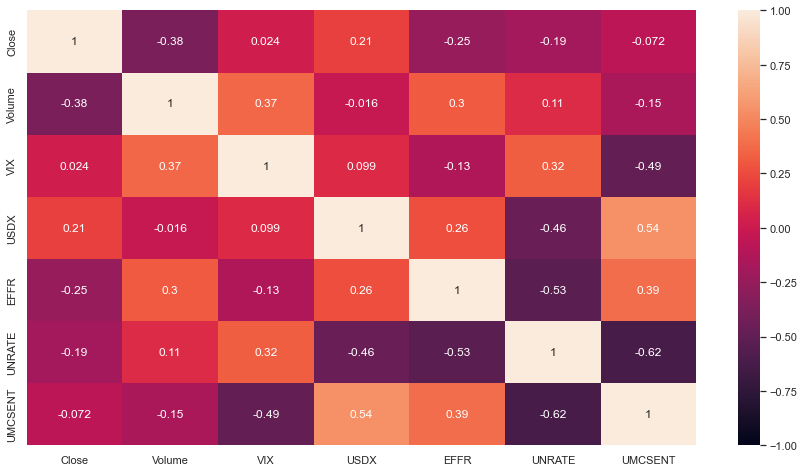

In [164]:
sns.set(rc = {'figure.figsize':(15,8)})
corr_m = df.corr()

sns.heatmap(corr_m, annot=True,vmin=-1,vmax=1)

## Data preprocessing

### Training set

In [165]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Test set

In [166]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## LSTM

### Create the model

In [167]:
model = keras.Sequential()
opt = keras.optimizers.Adam(learning_rate=0.001)
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 25)                2525      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [168]:
model.compile(optimizer=opt, loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 16, epochs=5)

Epoch 1/5
270/270 [==============================] - 22s 66ms/step - loss: 8.4108e-05
Epoch 2/5
270/270 [==============================] - 17s 64ms/step - loss: 1.6925e-05
Epoch 3/5
270/270 [==============================] - 21s 79ms/step - loss: 1.3082e-05
Epoch 4/5
270/270 [==============================] - 20s 72ms/step - loss: 1.2787e-05
Epoch 5/5
270/270 [==============================] - 21s 79ms/step - loss: 1.2703e-05


### Accuracy

In [169]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

35/35 [==============================] - 2s 48ms/step


5.17527504005692

## Results

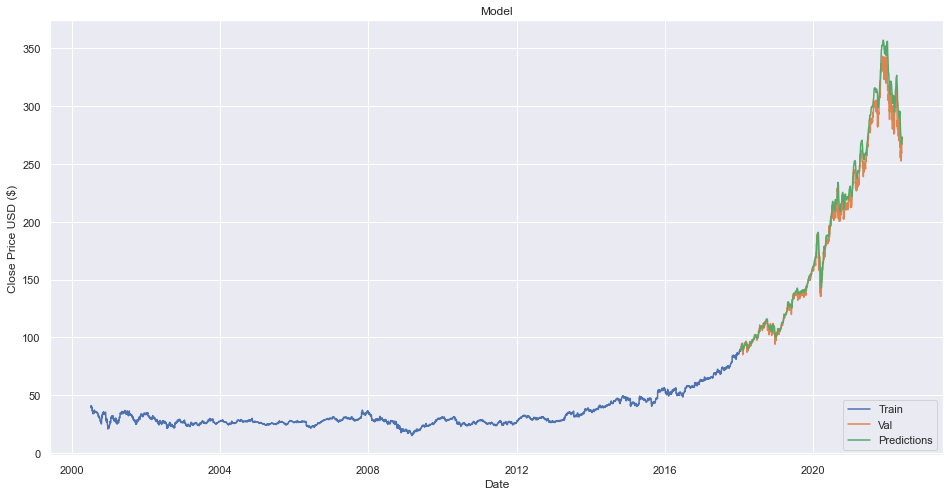

In [170]:
data = df.filter(['Close'])
train = data[:training_data_len].copy(deep=True)
validation = data[training_data_len:].copy(deep=True)
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()